# Background
Getting the path, loading the train/valid and creating datablock

~Create a python enviroment version 3.11.8 is possible then install everything in requirements.txt~

In [1]:
# pointing to the dataset directory on Google Drive
path = r'C:\Users\James\Desktop\bone freacture 451 project\bone_fracture_dataset_splitted'

path

'C:\\Users\\James\\Desktop\\bone freacture 451 project\\bone_fracture_dataset_splitted'

In [2]:
import yaml

with open(path+'/data.yaml', 'r') as f:
    data_structure = yaml.safe_load(f)
    print(data_structure)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 7, 'names': ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive'], 'roboflow': {'workspace': 'veda', 'project': 'bone-fracture-detection-daoon', 'version': 4, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4'}}


In [3]:
from fastai.vision.all import *
import yaml
import pandas as pd
import warnings

data_dir = Path(path)
trainValid_image_path = data_dir/'trainValid/images'
trainValid_label_path = data_dir/'trainValid/labels'

# The class names are directly taken from the YAML file
class_names = data_structure['names']

def get_label(file_path):
    # Construct the filename for the label file by removing the image extension and appending .txt
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path/label_file_name

    # Attempt to open the corresponding label file
    with open(label_file_path, 'r') as label_file:

        #print(label_file_path)

        label_values = label_file.read().split(' ')
        label = label_values[0]  # Assuming the first item is the label index

        #print(label)

        if not label:
            return 'N'
        return class_names[int(label)]

# Setting up the FastAI DataBlock
bone_fractures = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(size=256, min_scale=0.75)
)

# Load the data
dls = bone_fractures.dataloaders(trainValid_image_path, bs=64)

print(class_names)

['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']


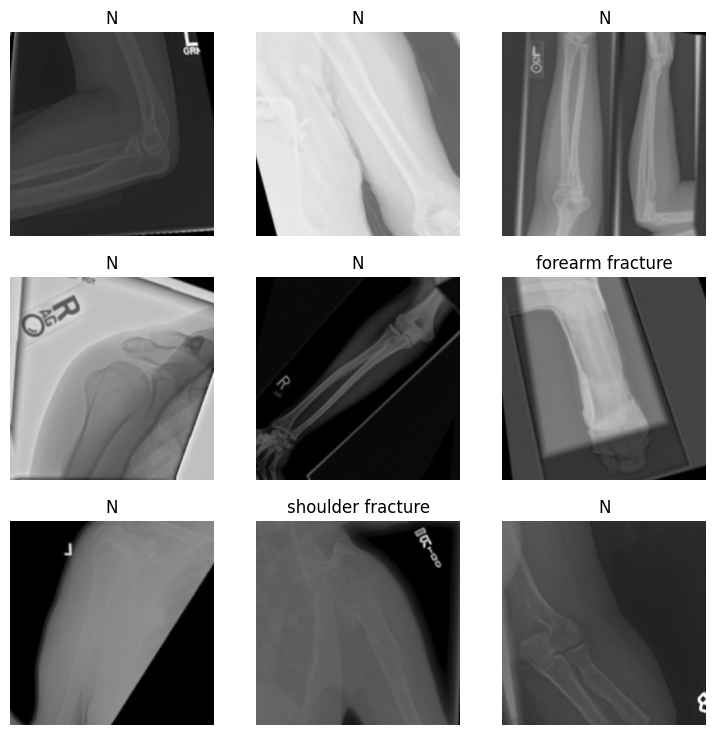

In [4]:
# Show an example
dls.show_batch()

# Counting the classes
(Run this to get the Labels varible)

In [4]:
from collections import Counter
import os

# Initialize a counter for all labels, including 'N'
label_counter = Counter()
labels = []

# Function to update the counter based on the label of each file
def update_label_counter(file_path):
    label_file_name = '.'.join(str(file_path.name).split('.')[:-1]) + '.txt'
    label_file_path = trainValid_label_path / label_file_name
    
    label = 'N'  # Default to 'N'
    with open(label_file_path, 'r') as label_file:
        label_values = label_file.read().strip().split(' ')
        if label_values[0].isdigit():
            label_index = int(label_values[0])
            if label_index < len(class_names):
                label = class_names[label_index]
                

    # Update the counter
    label_counter[label] += 1
    labels.append(label)

# Iterate over image files to update the counter
image_files = get_image_files(trainValid_image_path)
for image_file in image_files:
    update_label_counter(image_file)

# Display the count for each label, including 'N'
print(f"Label counts: {label_counter}")

Label counts: Counter({'N': 2002, 'fingers positive': 474, 'elbow positive': 334, 'shoulder fracture': 334, 'humerus': 330, 'forearm fracture': 320, 'wrist positive': 185})


In [14]:
#print(labels)

# CNN Creation/Testing

## Simple cnn

In [5]:
# Define a simple CNN using FastAI
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # Assuming 3-channel (RGB) input images
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 64 * 64, 512) # Adjust the input features based on your image size and architecture
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = self.pool(self.act2(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Adjust 'num_classes' to match the number of categories in your dataset
model1 = SimpleCNN(num_classes=7)

## More Complex CNN

In [10]:
# Define a simple CNN using FastAI
class ComplexCNN(nn.Module):
    def __init__(self, num_classes):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # Assuming 3-channel (RGB) input images
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 64 * 64, 512) 
        self.fc2 = nn.Linear(512, 1028)
        self.fc3 = nn.Linear(1028, num_classes)
    
    def forward(self, x):
        x = self.pool(self.act1(self.conv1(x)))
        x = self.pool(self.act2(self.conv2(x)))
        x = torch.flatten(x, 1) # Flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Adjust 'num_classes' to match the number of categories in your dataset
model2 = ComplexCNN(num_classes=7)

# Creating weighted classes so its "balanced"


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming 'class_names' includes all your valid labels as earlier defined
#class_names = ['N', 'elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# Updated class frequencies to reflect your Counter data
#class_freqs = np.array([2002, 334, 474, 320, 330, 334, 185])
#print(class_freqs)
# Classes indices should range from 0 to number of classes - 1
#class_indices = np.arange(len(class_names))
#print(class_indices)

# Calculate class weights for all valid labels in 'y'
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

#class_weights = compute_class_weight('balanced', classes=class_indices, y=class_freqs)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Ensure the tensor is on the correct device (CPU or GPU)
class_weights_tensor = class_weights_tensor.to(dls.device)

# Define the loss function with class weights
loss_func = CrossEntropyLossFlat(weight=class_weights_tensor)

# Create a Learner with the custom loss function

# Testing CNN's

NO LONGER NEEDED

epoch,train_loss,valid_loss,accuracy,time
0,1.926607,1.907131,0.142138,01:42


Better model found at epoch 0 with valid_loss value: 1.9071311950683594.


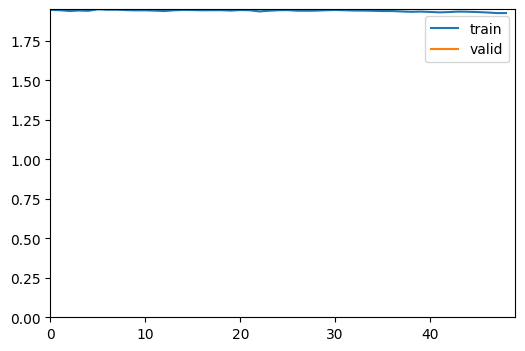

epoch,train_loss,valid_loss,accuracy,time
0,1.831686,1.834147,0.172327,01:43
1,1.796228,1.741852,0.211321,01:41
2,1.761205,1.702494,0.267925,01:44
3,1.713541,1.647162,0.244025,01:43
4,1.687751,1.602066,0.272956,01:42
5,1.644518,1.553007,0.250314,01:42
6,1.625264,1.563683,0.284277,01:44
7,1.597522,1.546919,0.300629,01:40
8,1.560992,1.491117,0.299371,01:38
9,1.543694,1.454560,0.290566,01:38


Better model found at epoch 0 with valid_loss value: 1.8341466188430786.


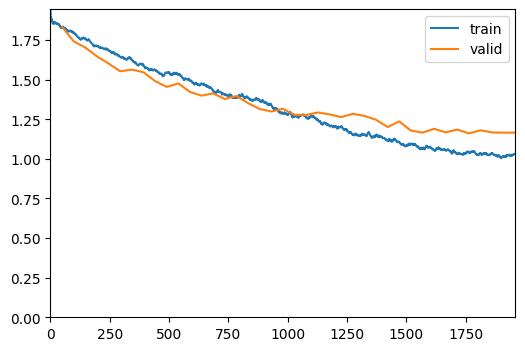

Better model found at epoch 1 with valid_loss value: 1.7418524026870728.
Better model found at epoch 2 with valid_loss value: 1.7024940252304077.
Better model found at epoch 3 with valid_loss value: 1.6471620798110962.
Better model found at epoch 4 with valid_loss value: 1.6020655632019043.
Better model found at epoch 5 with valid_loss value: 1.5530074834823608.
Better model found at epoch 7 with valid_loss value: 1.5469187498092651.
Better model found at epoch 8 with valid_loss value: 1.4911174774169922.
Better model found at epoch 9 with valid_loss value: 1.4545601606369019.
Better model found at epoch 11 with valid_loss value: 1.4228549003601074.
Better model found at epoch 12 with valid_loss value: 1.399338960647583.
Better model found at epoch 14 with valid_loss value: 1.3775982856750488.
Better model found at epoch 16 with valid_loss value: 1.3516738414764404.
Better model found at epoch 17 with valid_loss value: 1.3149906396865845.
Better model found at epoch 18 with valid_loss 

In [17]:
learn.fine_tune(40, 0.0008317, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,1.688158,1.984757,0.064151,01:40


Better model found at epoch 0 with valid_loss value: 1.9847568273544312.


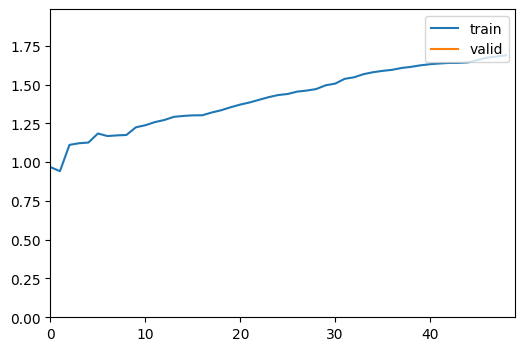

epoch,train_loss,valid_loss,accuracy,time
0,1.888056,1.836120,0.368553,01:39
1,1.795909,1.716946,0.256604,01:38
2,1.729440,1.690119,0.257862,01:38
3,1.701872,1.671147,0.262893,01:38
4,1.674955,1.600485,0.240252,01:39
5,1.673395,1.694721,0.254088,01:39
6,1.670823,1.660720,0.277987,01:38
7,1.650078,1.747257,0.220126,01:38
8,1.681633,1.585104,0.296855,01:38
9,1.643501,1.667148,0.338365,01:38


Better model found at epoch 0 with valid_loss value: 1.8361197710037231.


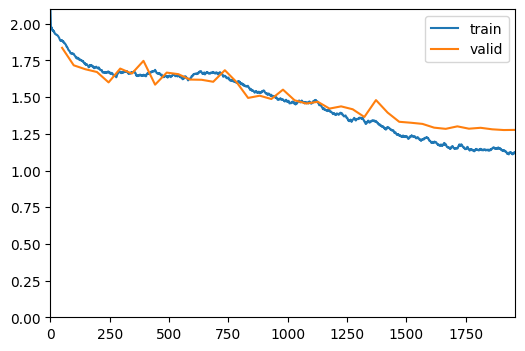

Better model found at epoch 1 with valid_loss value: 1.7169455289840698.
Better model found at epoch 2 with valid_loss value: 1.6901192665100098.
Better model found at epoch 3 with valid_loss value: 1.6711465120315552.
Better model found at epoch 4 with valid_loss value: 1.6004846096038818.
Better model found at epoch 8 with valid_loss value: 1.5851037502288818.
Better model found at epoch 16 with valid_loss value: 1.494664192199707.
Better model found at epoch 18 with valid_loss value: 1.487284541130066.
Better model found at epoch 20 with valid_loss value: 1.4785197973251343.
Better model found at epoch 21 with valid_loss value: 1.4563416242599487.
Better model found at epoch 23 with valid_loss value: 1.4218974113464355.
Better model found at epoch 25 with valid_loss value: 1.4172823429107666.
Better model found at epoch 26 with valid_loss value: 1.3647805452346802.
Better model found at epoch 29 with valid_loss value: 1.332024335861206.
Better model found at epoch 30 with valid_loss

In [18]:
learn.fine_tune(40, 0.008317, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

SuggestedLRs(valley=0.0014454397605732083)

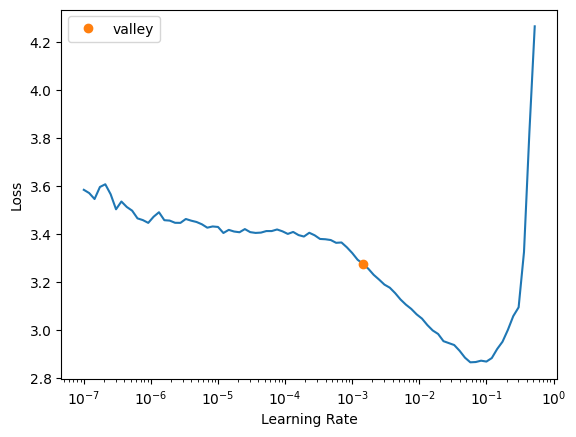

In [8]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.lr_find()

# Desnsenet121 testing


SuggestedLRs(valley=0.0008317637839354575)

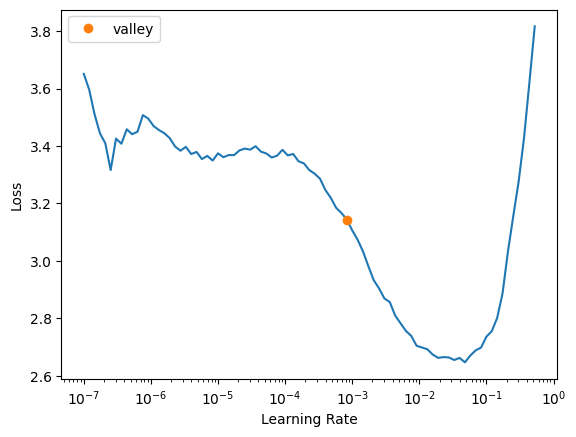

In [9]:
learnDenseNet121 = vision_learner(dls, densenet121, loss_func=loss_func, metrics=accuracy)
# Find an appropriate learning rate
learnDenseNet121.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.299090,1.236925,0.392453,09:20


Better model found at epoch 0 with valid_loss value: 1.2369250059127808.


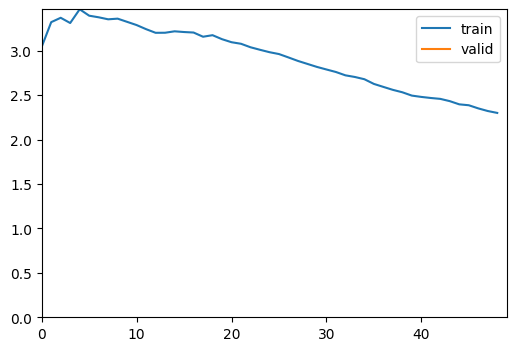

epoch,train_loss,valid_loss,accuracy,time
0,1.626919,1.143453,0.421384,10:52
1,1.461458,1.065323,0.462893,10:55
2,1.315504,0.938931,0.504403,10:51
3,1.156410,0.859200,0.534591,10:49
4,1.105192,0.764292,0.588679,10:49
5,0.979859,0.766847,0.640252,10:50
6,0.859687,0.679458,0.669182,10:50
7,0.768905,0.596585,0.706918,10:48
8,0.677975,0.566311,0.714465,10:52
9,0.620743,0.565496,0.743396,10:52


Better model found at epoch 0 with valid_loss value: 1.1434534788131714.


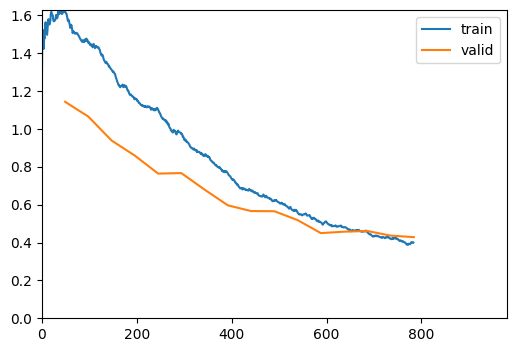

Better model found at epoch 1 with valid_loss value: 1.0653226375579834.
Better model found at epoch 2 with valid_loss value: 0.9389310479164124.
Better model found at epoch 3 with valid_loss value: 0.8592002391815186.
Better model found at epoch 4 with valid_loss value: 0.7642921805381775.
Better model found at epoch 6 with valid_loss value: 0.6794577836990356.
Better model found at epoch 7 with valid_loss value: 0.5965849757194519.
Better model found at epoch 8 with valid_loss value: 0.5663112998008728.
Better model found at epoch 9 with valid_loss value: 0.5654964447021484.
Better model found at epoch 10 with valid_loss value: 0.518549919128418.
Better model found at epoch 11 with valid_loss value: 0.4498504102230072.
Better model found at epoch 14 with valid_loss value: 0.43678560853004456.
Better model found at epoch 15 with valid_loss value: 0.4285224974155426.


KeyboardInterrupt: 

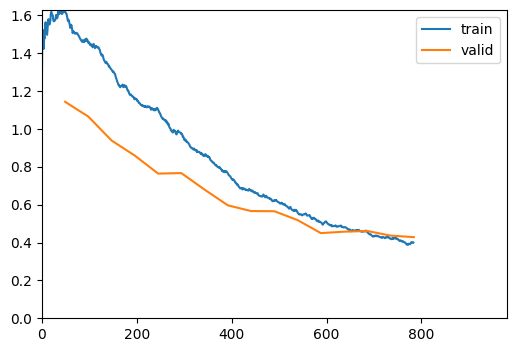

In [10]:
learnDenseNet121.fine_tune(20, 0.000831, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

# Resnet 34 Test

In [ ]:
learnResNet = vision_learner(dls, resnet34, loss_func=loss_func, metrics=accuracy)
# Find an appropriate learning rate
learnResNet.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,2.473724,1.372446,0.396226,03:47


Better model found at epoch 0 with valid_loss value: 1.3724455833435059.


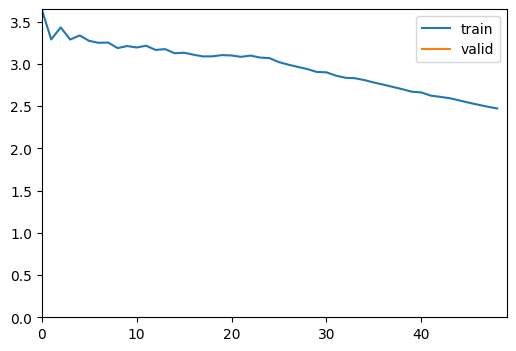

epoch,train_loss,valid_loss,accuracy,time
0,1.707496,1.155533,0.417610,05:05
1,1.553996,1.030666,0.436478,04:54
2,1.381295,0.927717,0.486792,04:54
3,1.247590,0.849072,0.524528,04:55
4,1.071440,0.782437,0.540881,04:53
5,0.935583,0.632390,0.642767,04:50
6,0.805173,0.575583,0.638994,04:53
7,0.715239,0.519786,0.703145,04:59
8,0.611068,0.565976,0.742138,05:00
9,0.534012,0.508874,0.771069,05:02


Better model found at epoch 0 with valid_loss value: 1.1555334329605103.


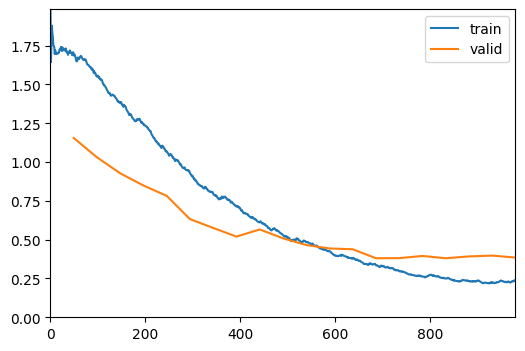

Better model found at epoch 1 with valid_loss value: 1.030666470527649.
Better model found at epoch 2 with valid_loss value: 0.927716851234436.
Better model found at epoch 3 with valid_loss value: 0.8490715622901917.
Better model found at epoch 4 with valid_loss value: 0.7824371457099915.
Better model found at epoch 5 with valid_loss value: 0.6323902606964111.
Better model found at epoch 6 with valid_loss value: 0.5755831599235535.
Better model found at epoch 7 with valid_loss value: 0.5197855830192566.
Better model found at epoch 9 with valid_loss value: 0.5088737607002258.
Better model found at epoch 10 with valid_loss value: 0.4655972719192505.
Better model found at epoch 11 with valid_loss value: 0.4436105787754059.
Better model found at epoch 12 with valid_loss value: 0.4382033944129944.
Better model found at epoch 13 with valid_loss value: 0.38040679693222046.
Better model found at epoch 16 with valid_loss value: 0.38037070631980896.


In [6]:
learnResNet = vision_learner(dls, resnet34, loss_func=loss_func, metrics=accuracy)
learnResNet.fine_tune(20, 0.001, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

# Resnet 50 Test

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\James/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.3MB/s]


SuggestedLRs(valley=0.001737800776027143)

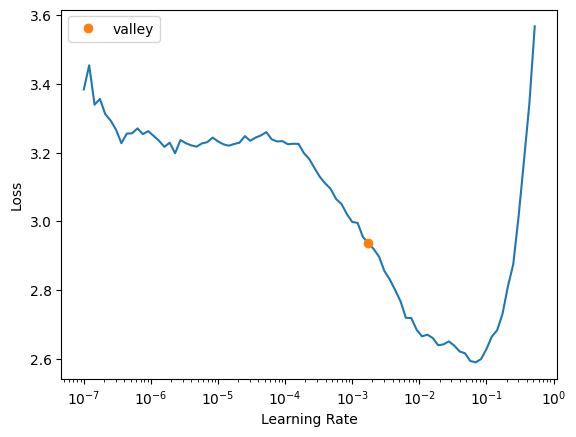

In [7]:
learnResNet50 = vision_learner(dls, resnet50, loss_func=loss_func, metrics=accuracy)
# Find an appropriate learning rate
learnResNet50.lr_find()

In [ ]:
learnResNet50 = vision_learner(dls, resnet50, loss_func=loss_func, metrics=accuracy)

learnResNet50.fine_tune(20, 0.001, cbs=[ShowGraphCallback(), EarlyStoppingCallback(min_delta=0.001, patience=10), SaveModelCallback()])

# Displaying the results of model

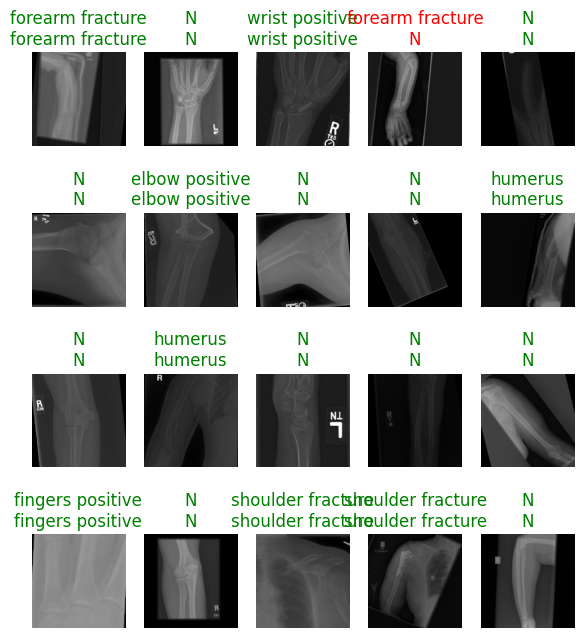

In [12]:
# visualize results (top row: true labels, bottom row: predicted labels)
learn.show_results(max_n = 20, figsize=(7,8))